## Data pre_processing script (section 5.1 and 5.2)

In [1]:
#import libraries 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [5]:
# Load the datasets
proteomics_data = pd.read_csv('proteomics_data_cleaned.csv') 

# Read the CSV file, specifying the correct index column
metabolomics_data = pd.read_csv('nmr_qc_derived.csv', index_col=0)

In [6]:
proteomics = proteomics_data 
metabolomics = metabolomics_data

In [7]:
# number of unique participants in each dataset
proteomics_participants = proteomics['eid'].nunique()
metabolomics_participants = metabolomics['eid'].nunique()

print(f"Number of unique participants in proteomics data: {proteomics_participants}")
print(f"Number of unique participants in metabolomics data: {metabolomics_participants}")

Number of unique participants in proteomics data: 53029
Number of unique participants in metabolomics data: 275342


### Understand the data

In [8]:
proteomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53029 entries, 0 to 53028
Columns: 2933 entries, eid to ZPR1
dtypes: float64(2923), int64(4), object(6)
memory usage: 1.2+ GB


In [9]:
proteomics.head(2)

,eid,gender,age_at_baseline,ethnicity,years_education,ethnic_group,BMI_levels,LTFU,dementia_diagnosis,dementia_date,...,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
0,1000099,Male,64,British,16.0,White,Overweight,No,0,NaN,...,0.3389,0.1471,-0.1771,1.2655,0.6081,0.84945,0.1845,-0.7430,-0.0720,-0.1630
1,1000373,Female,43,British,11.0,White,Normal,No,0,NaN,...,0.8142,0.1810,-0.0236,-0.4501,2.0355,-0.35495,0.2441,-0.8056,0.2395,0.8484


In [11]:
metabolomics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291059 entries, 1 to 291059
Columns: 329 entries, eid to Omega_6_pct_PUFA
dtypes: float64(327), int64(2)
memory usage: 732.8 MB


In [12]:
metabolomics.head(2)

,eid,visit_index,bOHbutyrate,Acetate,Acetoacetate,Acetone,Ala,Albumin,ApoA1,ApoB,...,Total_CE_pct,Total_FC_pct,Total_C_pct,Total_PL_pct,Total_TG_pct,Total_FC_pct_C,Total_CE_pct_C,Total_FC_by_CE,Omega_3_pct_PUFA,Omega_6_pct_PUFA
1,1000013,0,0.070411,0.013004,0.011579,0.013846,0.288476,36.685778,1.856792,0.975485,...,42.309744,15.454115,57.763859,34.561568,7.674573,26.753951,73.246049,0.365261,10.672419,89.327581
2,1000055,0,0.057902,0.013564,0.014763,0.013726,0.398710,36.798806,1.631454,0.892441,...,31.185933,11.983304,43.169237,31.119261,25.711502,27.758897,72.241103,0.384254,13.169422,86.830578


In [14]:
# understand the visit index count (baseline and follow up)
metabolomics['visit_index'].value_counts()

0    274351
1     16708
Name: visit_index, dtype: int64

In [15]:
# Count the number of entries per participant (eid)
metabolomics['eid'].value_counts()

2289105    2
5036664    2
5035510    2
5035935    2
2041600    2
          ..
2720786    1
2720798    1
2720806    1
2720823    1
6024109    1
Name: eid, Length: 275342, dtype: int64

In [16]:
# Display the data for a specific participant ID
specific_participant_id = 5036664
print(metabolomics[metabolomics['eid'] == specific_participant_id])

            eid  visit_index  bOHbutyrate   Acetate  Acetoacetate   Acetone  \
233989  5036664            0     0.058142  0.014888      0.006935  0.013599   
233990  5036664            1     0.129882  0.032044      0.015260  0.013591   

             Ala    Albumin     ApoA1      ApoB  ...  Total_CE_pct  \
233989  0.357669  35.297373  1.243427  0.477466  ...     32.835955   
233990  0.267488  39.862236  1.268869  0.528287  ...     33.977086   

        Total_FC_pct  Total_C_pct  Total_PL_pct  Total_TG_pct  Total_FC_pct_C  \
233989     11.724193    44.560148     35.056568     20.383284       26.310938   
233990     12.540528    46.517614     33.805305     19.677081       26.958665   

        Total_CE_pct_C  Total_FC_by_CE  Omega_3_pct_PUFA  Omega_6_pct_PUFA  
233989       73.689062        0.357054         13.300746         86.699254  
233990       73.041335        0.369088         12.266307         87.733693  

[2 rows x 329 columns]


In [17]:
#Include only metabolomics baseline values
# Step 1: Filter entries with visit_index 0
metabolomics= metabolomics[metabolomics['visit_index'] == 0]

# Reset the index for the filtered DataFrame
metabolomics.reset_index(drop=True, inplace=True)

In [18]:
metabolomics.head(2)

,eid,visit_index,bOHbutyrate,Acetate,Acetoacetate,Acetone,Ala,Albumin,ApoA1,ApoB,...,Total_CE_pct,Total_FC_pct,Total_C_pct,Total_PL_pct,Total_TG_pct,Total_FC_pct_C,Total_CE_pct_C,Total_FC_by_CE,Omega_3_pct_PUFA,Omega_6_pct_PUFA
0,1000013,0,0.070411,0.013004,0.011579,0.013846,0.288476,36.685778,1.856792,0.975485,...,42.309744,15.454115,57.763859,34.561568,7.674573,26.753951,73.246049,0.365261,10.672419,89.327581
1,1000055,0,0.057902,0.013564,0.014763,0.013726,0.398710,36.798806,1.631454,0.892441,...,31.185933,11.983304,43.169237,31.119261,25.711502,27.758897,72.241103,0.384254,13.169422,86.830578


In [19]:
metabolomics['visit_index'].value_counts()

0    274351
Name: visit_index, dtype: int64

In [20]:
metabolomics_data_1 = metabolomics

### Merge datasets

In [21]:
# Join based on proteomics data, including only those participants that also have metabolomics data
merged_on_proteomics_inner = pd.merge(proteomics, metabolomics_data_1, on='eid', how='inner')
participants_after_proteomics_inner_join = merged_on_proteomics_inner['eid'].nunique()

print(f"Number of participants after inner joining on proteomics data: {participants_after_proteomics_inner_join}")

Number of participants after inner joining on proteomics data: 30303


In [22]:
merged_on_proteomics_inner.head(5)

,eid,gender,age_at_baseline,ethnicity,years_education,ethnic_group,BMI_levels,LTFU,dementia_diagnosis,dementia_date,...,Total_CE_pct,Total_FC_pct,Total_C_pct,Total_PL_pct,Total_TG_pct,Total_FC_pct_C,Total_CE_pct_C,Total_FC_by_CE,Omega_3_pct_PUFA,Omega_6_pct_PUFA
0,1000644,Female,52,British,10.0,White,Overweight,No,0,NaN,...,35.527137,13.612703,49.139841,31.813449,19.046711,27.701968,72.298032,0.383164,6.847441,93.152559
1,1000700,Female,64,British,16.0,White,Overweight,No,0,NaN,...,40.032802,14.651346,54.684148,34.909830,10.406021,26.792674,73.207326,0.365984,12.454808,87.545192
2,1001054,Female,64,British,10.0,White,Obese,No,0,NaN,...,37.066676,14.952430,52.019105,30.727516,17.253378,28.744111,71.255889,0.403393,14.291576,85.708424
3,1001149,Female,42,British,16.0,White,Normal,No,0,NaN,...,37.225102,13.662934,50.888036,35.656855,13.455109,26.849010,73.150990,0.367035,8.454628,91.545372
4,1001350,Female,57,British,12.0,White,Overweight,No,0,NaN,...,35.739146,14.355283,50.094429,29.449679,20.455892,28.656446,71.343554,0.401668,14.355765,85.644235


In [23]:
# Dementia cases before prevelance removal
dementia_cases = merged_on_proteomics_inner[merged_on_proteomics_inner['dementia_diagnosis'] == 1]

dementia_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 26 to 30287
Columns: 3261 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3250), int64(5), object(6)
memory usage: 22.6+ MB


In [24]:
merged_on_proteomics_inner.dementia_diagnosis.value_counts()

0    29393
1      910
Name: dementia_diagnosis, dtype: int64

### Remove prevalence

In [25]:
dataset = merged_on_proteomics_inner

In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30303 entries, 0 to 30302
Columns: 3261 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3250), int64(5), object(6)
memory usage: 754.2+ MB


In [27]:
dataset['eid'].nunique()

30303

In [28]:
# Remove rows where 'dementia_prevalence' is 1.0
dataset= dataset[dataset['dementia_prevalence'] != 1.0]

#check rows and columns
len(dataset)

30273

In [29]:
# Dementia cases 
dataset.dementia_diagnosis.value_counts()

0    29393
1      880
Name: dementia_diagnosis, dtype: int64

In [30]:
#print("Column names:", dataset.columns.tolist())

### Number of proteomics and Metabolomics

In [31]:
# Get the index of the starting columns for proteomics and metabolomics
proteomics_start_col = 'AAMDC'
metabolomics_start_col = 'bOHbutyrate'

# Get the list of column names
columns = dataset.columns.tolist()

# Find the start index of proteomics and metabolomics columns
proteomics_start_idx = columns.index(proteomics_start_col)
metabolomics_start_idx = columns.index(metabolomics_start_col)

# Proteomics columns are from proteomics_start_idx to one before metabolomics_start_idx
proteomics_columns = columns[proteomics_start_idx:metabolomics_start_idx]

# Metabolomics columns are from metabolomics_start_idx to the end
metabolomics_columns = columns[metabolomics_start_idx:]

# Count the number of proteomics and metabolomics columns
num_proteomics = len(proteomics_columns)
num_metabolomics = len(metabolomics_columns)

print(f"Number of proteomics variables: {num_proteomics}")
print(f"Number of metabolomics variables: {num_metabolomics}")

Number of proteomics variables: 2918
Number of metabolomics variables: 327


### Dementia cases before removing missing data

In [32]:
# Now filter the DataFrame to include only cases with dementia diagnosis
dementia_cases = dataset[dataset['dementia_diagnosis'] == 1]

In [33]:
print(dementia_cases.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 26 to 30287
Columns: 3261 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3250), int64(5), object(6)
memory usage: 21.9+ MB
None


### Remove columns where more than 25% of data is missing 

In [34]:
# Set the threshold for missing values (21%)
threshold = 0.25

# Calculate the percentage of missing values for each column
missing_percentage_columns = dataset.isnull().mean()

# Identify columns with more than 25% missing data
columns_to_drop = missing_percentage_columns[missing_percentage_columns > threshold].index

# Define the columns to exclude from dropping
columns_to_exclude = ['eid', 'gender', 'age_at_baseline', 'ethnicity', 'ethnic_group','years_education', 'BMI_levels', 'LTFU', 'dementia_diagnosis', 'dementia_date', 'dementia_prevalence', 'dementia_incidence', 'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline']

# Exclude the defined columns from being dropped
columns_to_drop = [col for col in columns_to_drop if col not in columns_to_exclude]

# Calculate the percentage of missing data for the columns that were removed
missing_percentage_dropped_columns = missing_percentage_columns[columns_to_drop]

# Display the percentage of missing data for the removed columns
print(f"Percentage of missing data for the removed columns:")
for column, missing_percentage in missing_percentage_dropped_columns.items():
    print(f"{column}: {missing_percentage:.2%}")

# Drop the identified columns from the dataset
dataset_nomissing = dataset.drop(columns=columns_to_drop)

# Reset the index for the filtered DataFrame if needed (optional)
dataset_nomissing.reset_index(drop=True, inplace=True)

# Display the columns that were dropped
print(f"Columns dropped due to more than 25% missing data: {columns_to_drop}")

# Verify the remaining columns
print("Remaining columns in the dataset after dropping:")
print(dataset_nomissing.columns)

# Compare the number of columns before and after filtering
initial_column_count = len(dataset.columns)
filtered_column_count = len(dataset_nomissing.columns)
print(f"Initial number of columns: {initial_column_count}")
print(f"Number of columns after filtering: {filtered_column_count}")

Percentage of missing data for the removed columns:
CST1: 28.49%
GLIPR1: 99.68%
NPM1: 73.65%
PCOLCE: 63.45%
Columns dropped due to more than 25% missing data: ['CST1', 'GLIPR1', 'NPM1', 'PCOLCE']
Remaining columns in the dataset after dropping:
Index(['eid', 'gender', 'age_at_baseline', 'ethnicity', 'years_education',
       'ethnic_group', 'BMI_levels', 'LTFU', 'dementia_diagnosis',
       'dementia_date',
       ...
       'Total_CE_pct', 'Total_FC_pct', 'Total_C_pct', 'Total_PL_pct',
       'Total_TG_pct', 'Total_FC_pct_C', 'Total_CE_pct_C', 'Total_FC_by_CE',
       'Omega_3_pct_PUFA', 'Omega_6_pct_PUFA'],
      dtype='object', length=3257)
Initial number of columns: 3261
Number of columns after filtering: 3257


In [35]:
# Compare the number of columns before and after filtering
initial_column_count = len(dataset.columns)
filtered_column_count = len(dataset_nomissing.columns)
print(f"Initial number of columns: {initial_column_count}")
print(f"Number of columns after filtering: {filtered_column_count}")

Initial number of columns: 3261
Number of columns after filtering: 3257


In [36]:
dataset_nomissing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30273 entries, 0 to 30272
Columns: 3257 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3246), int64(5), object(6)
memory usage: 752.3+ MB


In [37]:
# Filter the DataFrame to include only cases with dementia diagnosis
dementia_cases_1 = dataset_nomissing[dataset_nomissing['dementia_diagnosis'] == 1]
dementia_cases_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 26 to 30257
Columns: 3257 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3246), int64(5), object(6)
memory usage: 21.9+ MB


In [39]:
# Q&A to test if removal of data was done correctly

# Verify that no column in the filtered dataset has more than 20% missing values
max_missing_percentage_col = dataset_nomissing.isnull().mean().max()
assert max_missing_percentage_col >= 0.25, f"Some columns have more than 25% missing values: {max_missing_percentage_col}"

# Compare the number of columns before and after filtering
initial_column_count = len(dataset.columns)
filtered_column_count = len(dataset_nomissing.columns)
print(f"Initial number of columns: {initial_column_count}")
print(f"Number of columns after filtering: {filtered_column_count}")

# Display some columns to manually inspect
print("Sample columns from the filtered dataset:")
print(dataset_nomissing.sample(5, axis=1))  # Display 5 random columns

# Display the missing value percentage for the displayed columns for confirmation
sample_missing_percentage_col = dataset_nomissing.sample(5, axis=1).isnull().mean()
print("Missing value percentage for the sample columns:")
print(sample_missing_percentage_col)

Initial number of columns: 3261
Number of columns after filtering: 3257
Sample columns from the filtered dataset:
         KRT19     ITPA     GSN     PMCH    ULBP2
0      0.86495 -0.16735  0.0243 -0.07800  0.55390
1     -0.16860 -0.19945 -0.0912 -0.15185  0.25540
2     -0.91865 -0.06855  0.1879  1.46590 -0.02590
3     -1.12060  0.23035 -0.1321  0.82910 -0.17930
4      0.43680  5.66325 -0.2906  0.58480 -0.21460
...        ...      ...     ...      ...      ...
30268  0.58350      NaN     NaN      NaN  0.02445
30269  0.60720  0.12725 -0.1001 -0.35580  1.28290
30270      NaN  1.36315  0.0081  1.06520 -0.12980
30271 -0.07920  1.22925  0.0587  1.50085  0.06620
30272  0.67760 -0.70675  0.5771 -0.44000 -0.05500

[30273 rows x 5 columns]
Missing value percentage for the sample columns:
TNXB       0.028012
DSG3       0.023255
SCGB3A2    0.025039
RPGR       0.201136
PRSS8      0.031282
dtype: float64


In [40]:
# Calculate the percentage of missing values for each column in the filtered dataset
missing_percentage_columns = dataset_nomissing.isnull().mean()

# Find the maximum and minimum percentage of missing data in the filtered columns
max_missing_percentage_col = missing_percentage_columns.max()
min_missing_percentage_col = missing_percentage_columns.min()

# Display the results
print(f"Maximum percentage of missing data in filtered columns: {max_missing_percentage_col:.2%}")
print(f"Minimum percentage of missing data in filtered columns: {min_missing_percentage_col:.2%}")

Maximum percentage of missing data in filtered columns: 97.09%
Minimum percentage of missing data in filtered columns: 0.00%


In [41]:
# Set a threshold to investigate high missing percentage columns
high_missing_threshold = 0.25

# Identify columns with more than the specified threshold of missing data
high_missing_columns = missing_percentage_columns[missing_percentage_columns > high_missing_threshold]

# Display the columns with high missing data percentages
print(f"Columns with more than {high_missing_threshold*100}% missing data:")
print(high_missing_columns)

Columns with more than 25.0% missing data:
dementia_date                     0.970931
dementia_prevalence               0.970931
dementia_incidence                0.970931
Diagnosis_years_since_baseline    0.970931
dtype: float64


### Remove participants where 50% or more data is missing

EIDs and percentage of missing data for the removed rows:
EID: 1028632, Missing data: 50.57%
EID: 1041038, Missing data: 55.42%
EID: 1041916, Missing data: 69.08%
EID: 1063758, Missing data: 56.06%
EID: 1074887, Missing data: 60.82%
EID: 1079991, Missing data: 62.39%
EID: 1082118, Missing data: 78.39%
EID: 1100739, Missing data: 52.99%
EID: 1110829, Missing data: 78.20%
EID: 1138262, Missing data: 51.52%
EID: 1138952, Missing data: 51.27%
EID: 1145151, Missing data: 50.54%
EID: 1160066, Missing data: 55.45%
EID: 1164439, Missing data: 52.04%
EID: 1166482, Missing data: 70.16%
EID: 1174831, Missing data: 59.29%
EID: 1175581, Missing data: 51.40%
EID: 1205052, Missing data: 63.46%
EID: 1205200, Missing data: 56.09%
EID: 1229464, Missing data: 61.07%
EID: 1257886, Missing data: 55.97%
EID: 1278077, Missing data: 57.51%
EID: 1298578, Missing data: 78.66%
EID: 1301491, Missing data: 56.00%
EID: 1310092, Missing data: 62.45%
EID: 1322706, Missing data: 51.00%
EID: 1389329, Missing data: 56.0

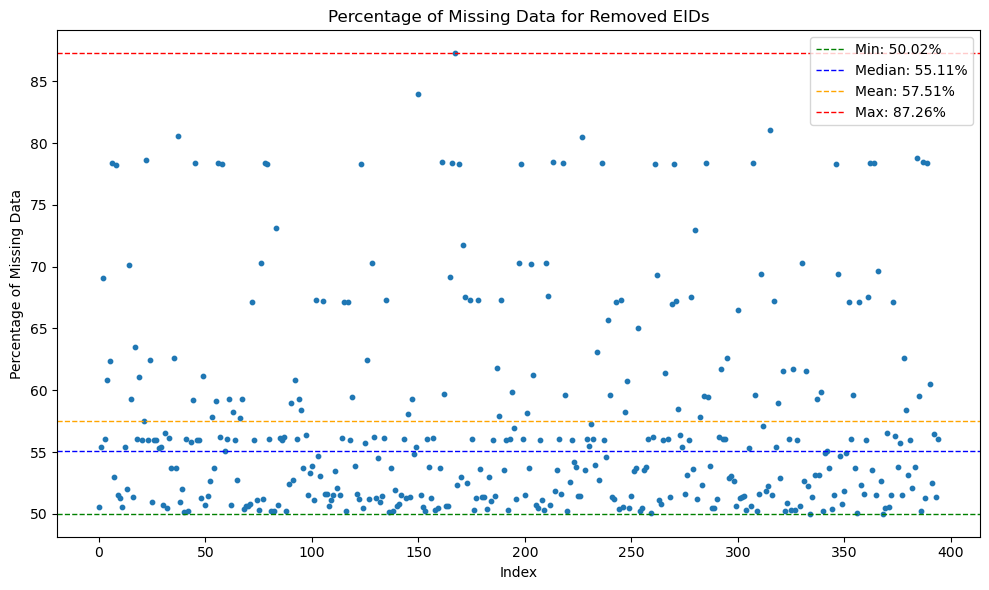

Number of remaining rows after filtering:
29878
Filtered metabolomics data:
           eid  gender  age_at_baseline ethnicity  years_education  \
0      1000644  Female               52   British             10.0   
1      1000700  Female               64   British             16.0   
2      1001054  Female               64   British             10.0   
3      1001149  Female               42   British             16.0   
4      1001350  Female               57   British             12.0   
...        ...     ...              ...       ...              ...   
29873  6022974    Male               57   British             16.0   
29874  6023242    Male               67   British             11.0   
29875  6023495    Male               59   British             16.0   
29876  6023562  Female               68   British             10.0   
29877  6023876  Female               51   British             11.0   

      ethnic_group  BMI_levels LTFU  dementia_diagnosis dementia_date  ...  \
0    

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set the threshold for missing values (20%)
threshold = 0.5

# Calculate the percentage of missing values for each row
missing_percentage = dataset_nomissing.isnull().mean(axis=1)

# Identify the rows with more than 20% missing data
rows_to_remove = missing_percentage[missing_percentage > threshold]

# Display the EID and the percentage of missing data for the removed rows
print("EIDs and percentage of missing data for the removed rows:")
for idx in rows_to_remove.index:
    eid = dataset_nomissing.iloc[idx]['eid']
    missing_percentage_value = rows_to_remove[idx]
    print(f"EID: {eid}, Missing data: {missing_percentage_value:.2%}")

    
# Create the output directory if it doesn't exist
output_dir = 'output_data_analysis'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Collect EIDs and their missing data percentages
removed_data = pd.DataFrame({
    'EID': dataset_nomissing.loc[rows_to_remove.index, 'eid'],
    'Missing_Percentage': rows_to_remove.values * 100  # Convert to percentage
})

# Plot the data
plt.figure(figsize=(10, 6))

# Plot individual points
plt.scatter(range(len(removed_data)), removed_data['Missing_Percentage'], s=10)
plt.xlabel('Index')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data for Removed EIDs')


# Add horizontal lines for min, median, mean, and max
min_value = removed_data['Missing_Percentage'].min()
median_value = removed_data['Missing_Percentage'].median()
mean_value = removed_data['Missing_Percentage'].mean()
max_value = removed_data['Missing_Percentage'].max()

plt.axhline(min_value, color='green', linestyle='dashed', linewidth=1, label=f'Min: {min_value:.2f}%')
plt.axhline(median_value, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f}%')
plt.axhline(mean_value, color='orange', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f}%')
plt.axhline(max_value, color='red', linestyle='dashed', linewidth=1, label=f'Max: {max_value:.2f}%')

plt.legend()
plt.tight_layout()
plt.show()
# Save the plot as a file in the output directory
output_path = os.path.join(output_dir, 'Percentage of Missing Data for Removed EIDs.png')
plt.savefig(output_path)
plt.close()  # Close the plot to free up memory

# Filter the DataFrame to include only rows with <= 20% missing values
dataset_nomissing_filtered = dataset_nomissing[missing_percentage <= threshold].copy()

# Reset the index for the filtered DataFrame
dataset_nomissing_filtered.reset_index(drop=True, inplace=True)

# Verify the number of remaining rows
print("Number of remaining rows after filtering:")
print(len(dataset_nomissing_filtered))

# Display the filtered dataset
print("Filtered metabolomics data:")
print(dataset_nomissing_filtered)

In [43]:
# Verify that no row in the filtered dataset has more than 50% missing values
max_missing_percentage = dataset_nomissing_filtered.isnull().mean(axis=1).max()
assert max_missing_percentage <= 0.5, f"Some rows have more than 50% missing values: {max_missing_percentage}"

# Compare the number of rows before and after filtering
initial_row_count = len(dataset)
clean_variables_row_count = len(dataset_nomissing)
filtered_row_count = len(dataset_nomissing_filtered)
print(f"Initial number of rows: {initial_row_count}")
print(f"Rows after variables removal: {clean_variables_row_count}")
print(f"Number of rows after filtering: {filtered_row_count}")

# Display some rows to manually inspect
print("Sample rows from the filtered dataset:")
print(dataset_nomissing_filtered.sample(5))  # Display 5 random rows

# Display the missing value percentage for the displayed rows for confirmation
sample_missing_percentage = dataset_nomissing_filtered.sample(5).isnull().mean(axis=1)
print("Missing value percentage for the sample rows:")
print(sample_missing_percentage)

Initial number of rows: 30273
Rows after variables removal: 30273
Number of rows after filtering: 29878
Sample rows from the filtered dataset:
           eid  gender  age_at_baseline                   ethnicity  \
16115  3703667  Female               44                     British   
9074   2516586  Female               53                      Indian   
15762  3642643    Male               47  Any other Asian background   
15827  3654456    Male               66  Any other white background   
27548  5636073  Female               42                     British   

       years_education ethnic_group  BMI_levels LTFU  dementia_diagnosis  \
16115             16.0        White  Overweight   No                   0   
9074               9.0      S.Asian  Overweight   No                   0   
15762             16.0      S.Asian  Overweight   No                   0   
15827             16.0        White      Normal   No                   0   
27548             16.0        White  Overweight   

In [44]:
# Calculate the percentage of missing values for each row in the filtered dataset
missing_percentage_filtered = dataset_nomissing_filtered.isnull().mean(axis=1)

# Find the maximum and minimum percentage of missing data in the filtered rows
max_missing_percentage = missing_percentage_filtered.max()
min_missing_percentage = missing_percentage_filtered.min()

# Display the results
print(f"Maximum percentage of missing data in filtered rows: {max_missing_percentage:.2%}")
print(f"Minimum percentage of missing data in filtered rows: {min_missing_percentage:.2%}")

Maximum percentage of missing data in filtered rows: 49.98%
Minimum percentage of missing data in filtered rows: 0.00%


In [45]:
# filter the DataFrame to include only cases with dementia diagnosis
dementia_cases = dataset_nomissing_filtered[dataset_nomissing_filtered['dementia_diagnosis'] == 1]
dementia_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 26 to 29862
Columns: 3257 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3246), int64(5), object(6)
memory usage: 21.7+ MB


In [46]:
dataset_nomissing_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29878 entries, 0 to 29877
Columns: 3257 entries, eid to Omega_6_pct_PUFA
dtypes: float64(3246), int64(5), object(6)
memory usage: 742.4+ MB


### Final number of dementia cases and controls after exclusions applied

In [47]:
dataset_nomissing_filtered.dementia_diagnosis.value_counts()

0    29006
1      872
Name: dementia_diagnosis, dtype: int64

### Create new variable Years_Group (to categorise cases into thresholds)

     Count  Percentage
0.0  29006   97.081465
2.0    122    0.408327
3.0    382    1.278533
4.0    368    1.231675

Bin intervals associated with each label:
1: [-inf, 0]
2: [0, 5]
3: [5, 10]
4: [10, inf]
0: No specific interval (participants without dementia diagnosis)
0.0: Count = 29006.0, Percentage = 97.08%
2.0: Count = 122.0, Percentage = 0.41%
3.0: Count = 382.0, Percentage = 1.28%
4.0: Count = 368.0, Percentage = 1.23%


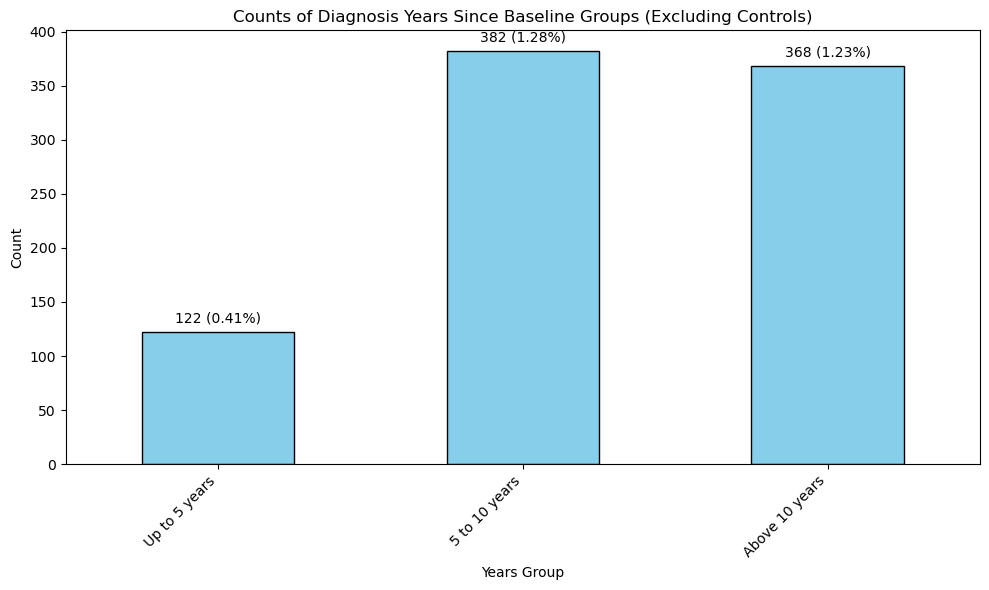

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bins and labels
bins = [-float('inf'), 0, 5, 10, float('inf')]
labels = ['Up to baseline', 'Up to 5 years', '5 to 10 years', 'Above 10 years']  # Labels for the plot

# Define numeric codes for each category
numeric_codes = [1, 2, 3, 4]  # Numeric codes for the categories

# Create a dictionary to map numeric codes to bin intervals
bin_dict = {code: bins[i:i+2] for i, code in enumerate(numeric_codes)}

# Add 'Controls' to the dictionary (no specific interval)
bin_dict[0] = 'No specific interval (participants without dementia diagnosis)'

# Categorise the data into bins and assign numeric codes
dataset_nomissing_filtered['Years_Group'] = pd.cut(dataset_nomissing_filtered['Diagnosis_years_since_baseline'], bins=bins, labels=numeric_codes, right=False).astype(float)

# Identify controls (participants with no dementia diagnosis)
controls_mask = dataset_nomissing_filtered['dementia_diagnosis'] == 0
dataset_nomissing_filtered.loc[controls_mask, 'Years_Group'] = 0

# Calculate the value counts and percentages
value_counts = dataset_nomissing_filtered['Years_Group'].value_counts().sort_index()
value_percentages = dataset_nomissing_filtered['Years_Group'].value_counts(normalize=True).sort_index() * 100

# Combine counts and percentages into a DataFrame
distribution_df = pd.DataFrame({'Count': value_counts, 'Percentage': value_percentages})

# Display the counts and percentages, including the number of controls
print(distribution_df)

# Print the bin dictionary
print("\nBin intervals associated with each label:")
for code, interval in bin_dict.items():
    print(f"{code}: {interval}")

# Print key-value pairs for each category
for category, row in distribution_df.iterrows():
    print(f"{category}: Count = {row['Count']}, Percentage = {row['Percentage']:.2f}%")

# Mapping of numeric codes to labels for the plot
code_to_label = {0: 'Controls', 1: 'Up to baseline', 2: 'Up to 5 years', 3: '5 to 10 years', 4: 'Above 10 years'}

# Plot the counts and percentages, excluding 'Controls'
plot_df = distribution_df.drop(index=0)

plt.figure(figsize=(10, 6))
ax = plot_df['Count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Years Group')
plt.ylabel('Count')
plt.title('Counts of Diagnosis Years Since Baseline Groups (Excluding Controls)')
ax.set_xticklabels([code_to_label[x] for x in plot_df.index], rotation=45, ha='right')

# Add the count and percentage values on top of the bars
for i, p in enumerate(ax.patches):
    count = plot_df['Count'].iloc[i]
    percentage = plot_df['Percentage'].iloc[i]
    ax.annotate(f"{count} ({percentage:.2f}%)", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()


output_path = os.path.join(output_dir, 'Counts of Diagnosis Years Since Baseline Groups.png')
plt.savefig(output_path)
plt.close()  # Close the plot to free up memory


In [55]:
dataset_nomissing_filtered['Years_Group'].value_counts()

0.0    29006
3.0      382
4.0      368
2.0      122
Name: Years_Group, dtype: int64

### Check outliers in the data

Existing excluded columns: ['eid', 'gender', 'age_at_baseline', 'ethnicity', 'ethnic_group', 'years_education', 'BMI_levels', 'LTFU', 'dementia_diagnosis', 'dementia_date', 'dementia_prevalence', 'dementia_incidence', 'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline', 'Years_Group']
Columns to drop from numeric data: ['eid', 'age_at_baseline', 'years_education', 'dementia_diagnosis', 'dementia_prevalence', 'dementia_incidence', 'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline', 'Years_Group']
Columns with outliers: []


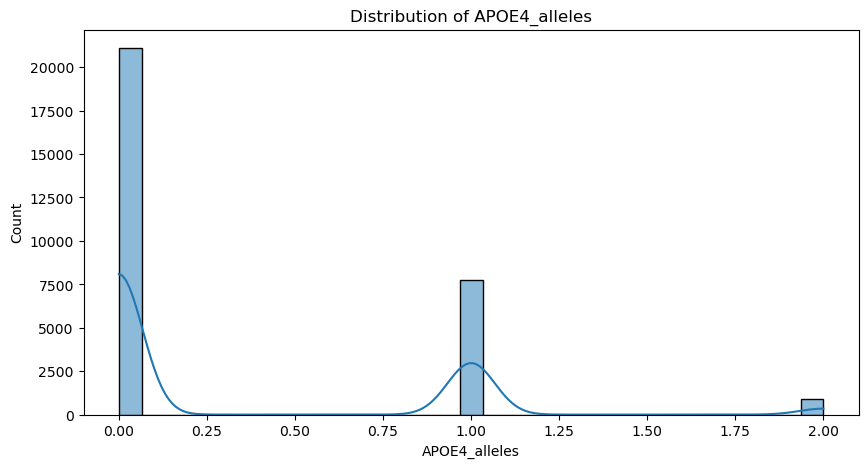

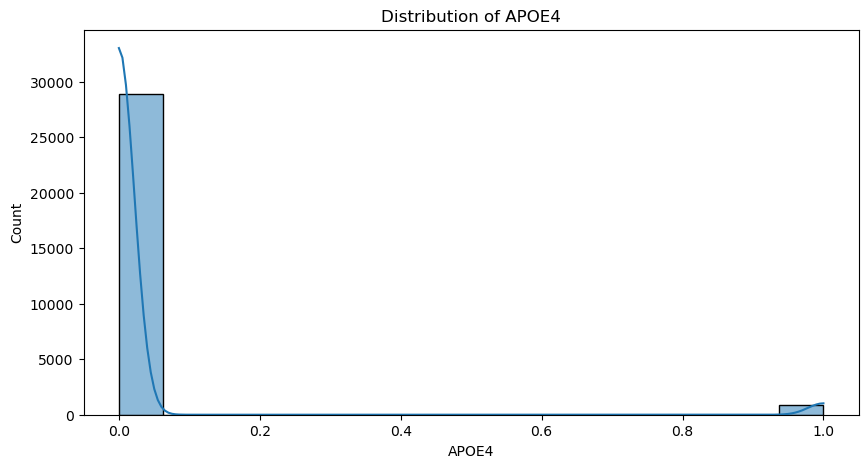

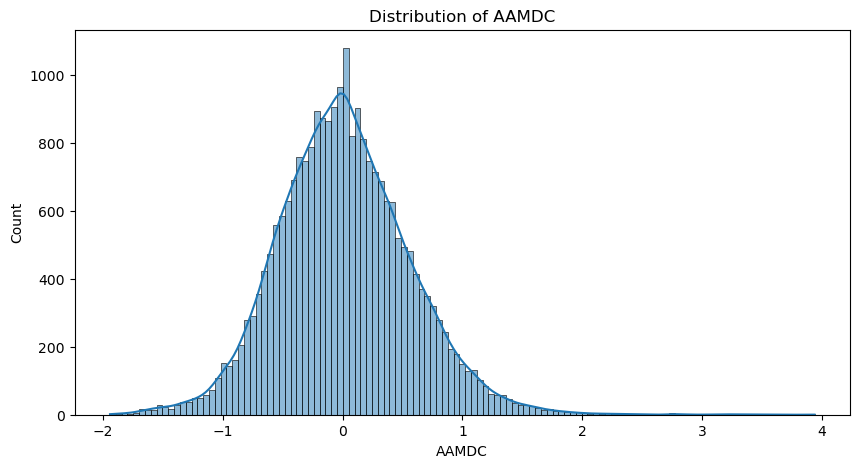

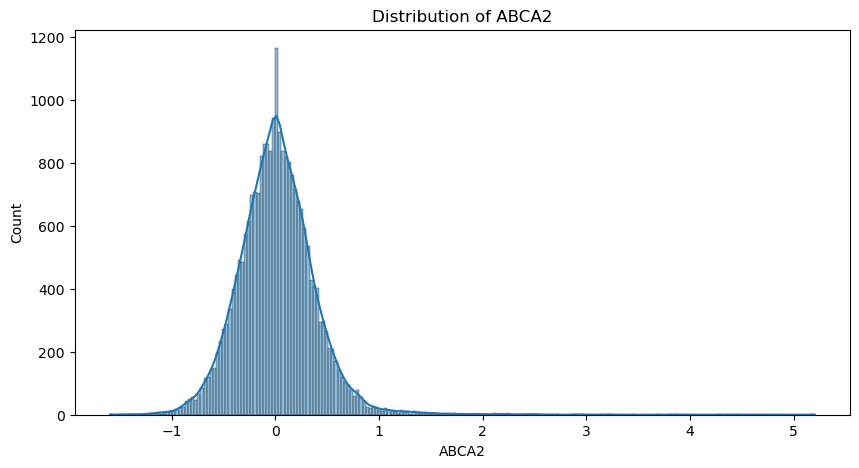

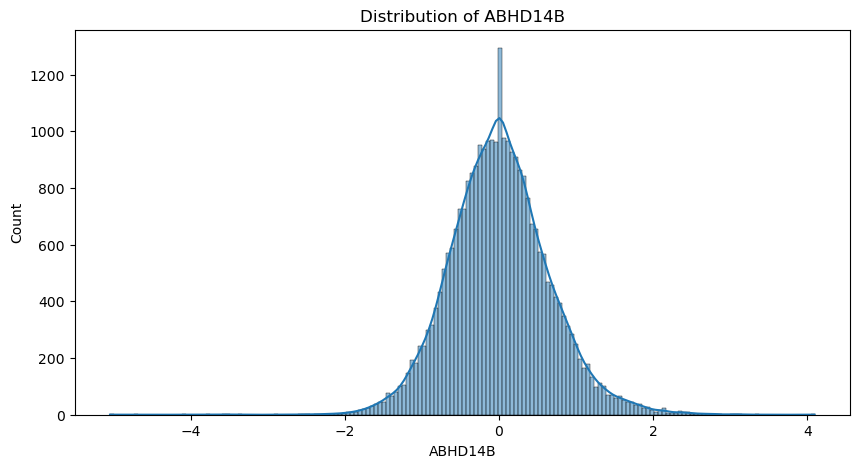

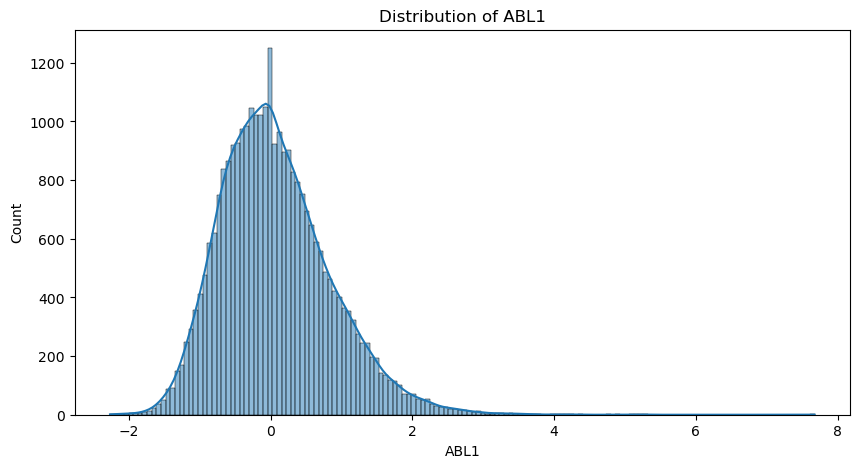

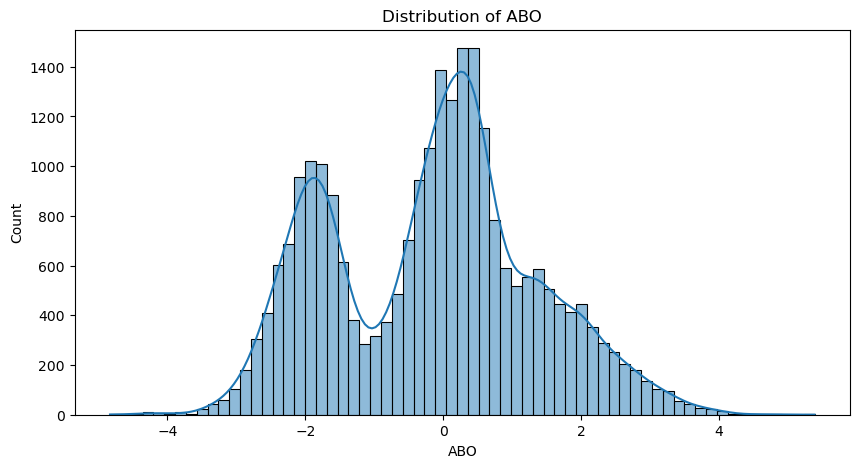

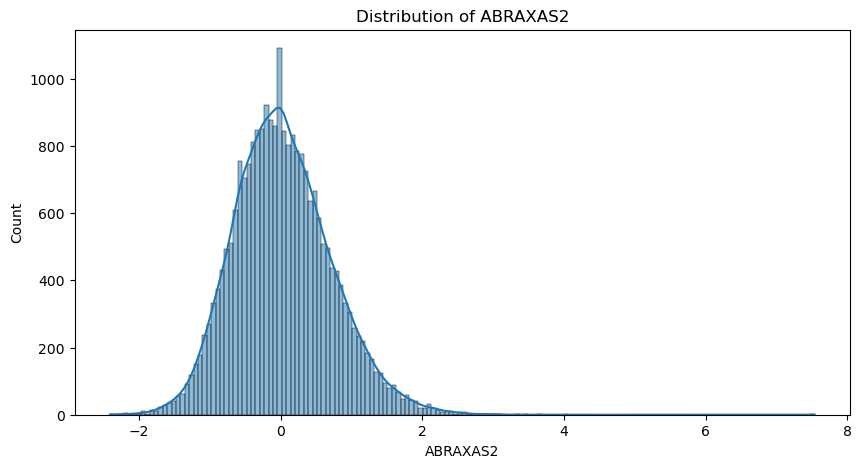

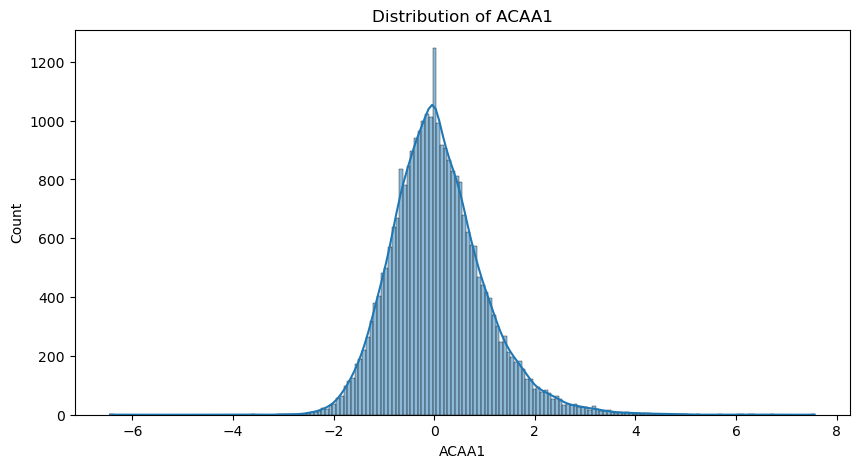

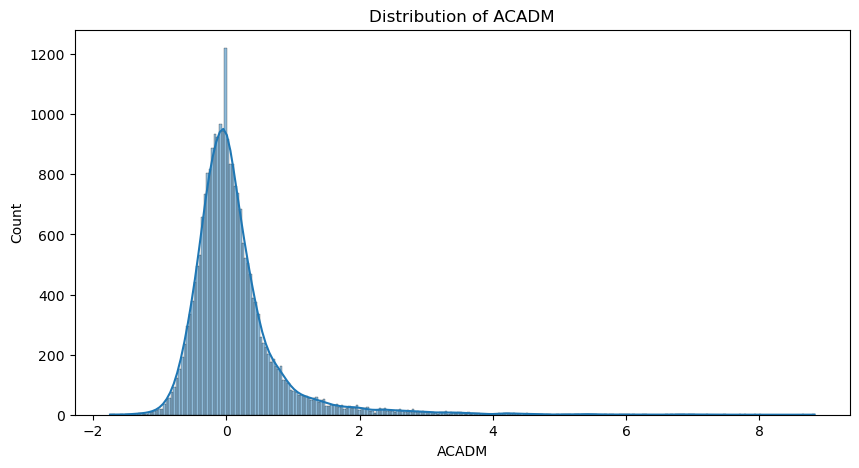

No outliers detected in the dataset.


In [67]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load your data into a DataFrame
data = dataset_nomissing_filtered

# Columns to exclude from the analysis
excluded_columns = ['eid', 'gender', 'age_at_baseline', 'ethnicity', 'ethnic_group','years_education', 'BMI_levels', 'LTFU', 
                    'dementia_diagnosis', 'dementia_date', 'dementia_prevalence', 'dementia_incidence', 
                    'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline', 'Years_Group']

# Strip any whitespace from the column names
data.columns = data.columns.str.strip()

# Verify which excluded columns exist in the DataFrame
existing_excluded_columns = [col for col in excluded_columns if col in data.columns]
print("Existing excluded columns:", existing_excluded_columns)

# Filter only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Ensure we only drop columns that exist in the numeric data
columns_to_drop = [col for col in existing_excluded_columns if col in numeric_data.columns]
print("Columns to drop from numeric data:", columns_to_drop)

# Drop the existing excluded columns from numeric data
numeric_data = numeric_data.drop(columns=columns_to_drop)

# Compute the Z-scores of the numeric variables with a lower threshold
z_scores = numeric_data.apply(zscore)

# Define a lower threshold to identify outliers (e.g., Z-score > 2 or < -2)
threshold = 2
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Identify columns with outliers
columns_with_outliers = outliers.any()

# Get the columns with outliers
outlier_columns = columns_with_outliers[columns_with_outliers].index.tolist()
print("Columns with outliers:", outlier_columns)

# Create the output directory if it doesn't exist
output_dir = 'output_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Visualize the distributions of a few columns to understand their spread
sample_columns = numeric_data.columns[:10]  # Adjust this to visualize different columns if needed
for col in sample_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    # Save the plot as a file in the output directory
    plt.savefig(os.path.join(output_dir, f'distribution_{col}.png'))
    plt.close()  # Close the plot to free up memory

# Visualize using boxplots for columns with outliers
if len(outlier_columns) > 0:
    numeric_data[outlier_columns].boxplot(figsize=(15, 10))
    plt.xticks(rotation=90)
    plt.show()
    # Save the boxplot as a file in the output directory
    plt.savefig(os.path.join(output_dir, 'boxplot_outliers.png'))
    plt.close()  # Close the plot to free up memory
else:
    print("No outliers detected in the dataset.")


### Missing data checks analysis (check for MCAR and MAR assumptions)

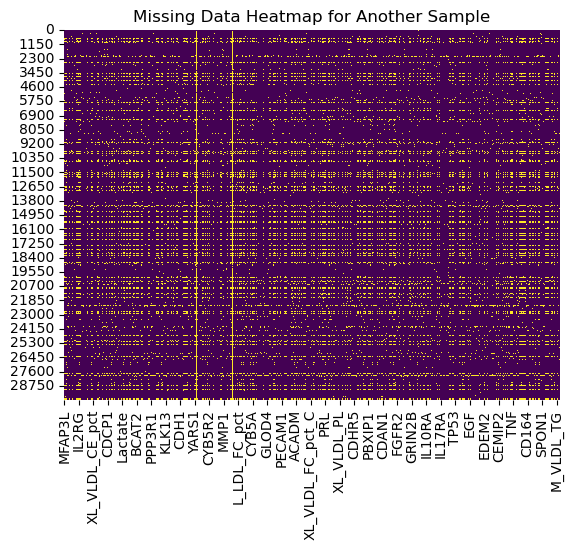

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


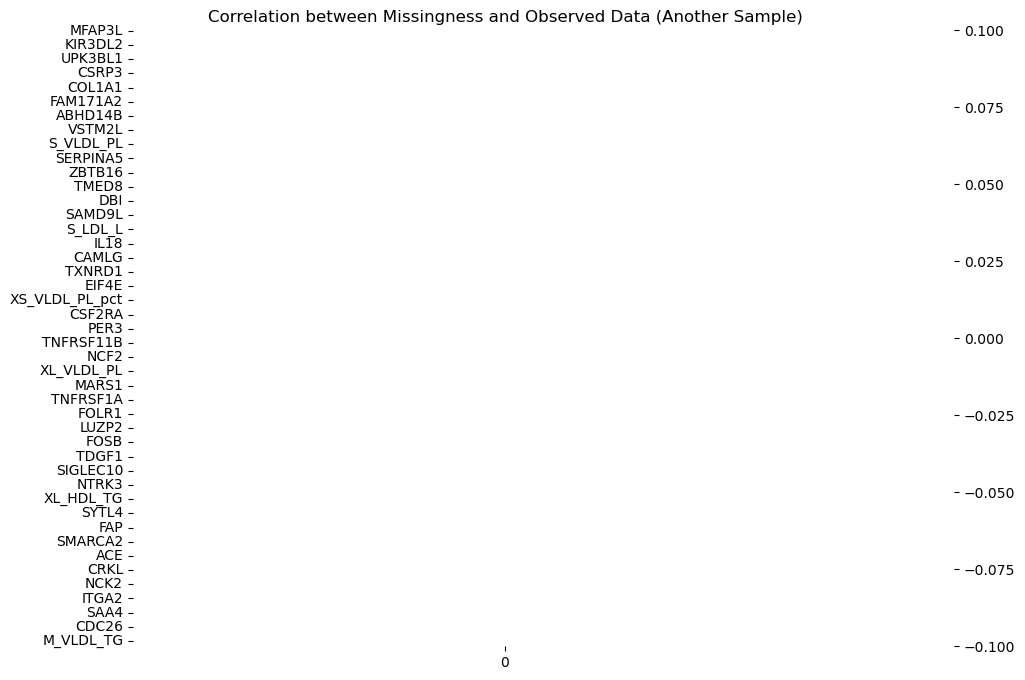

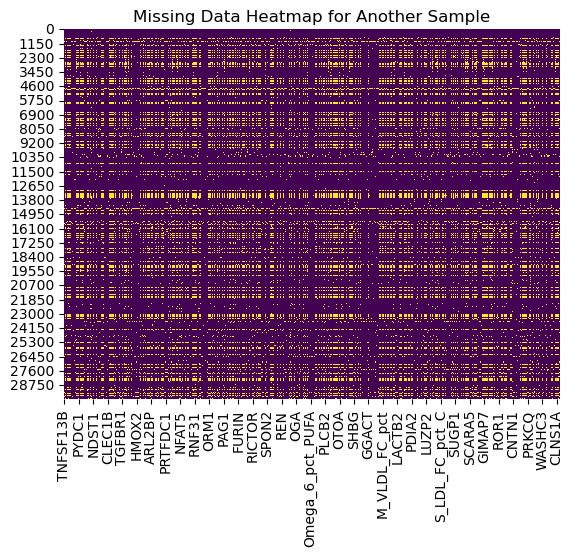

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


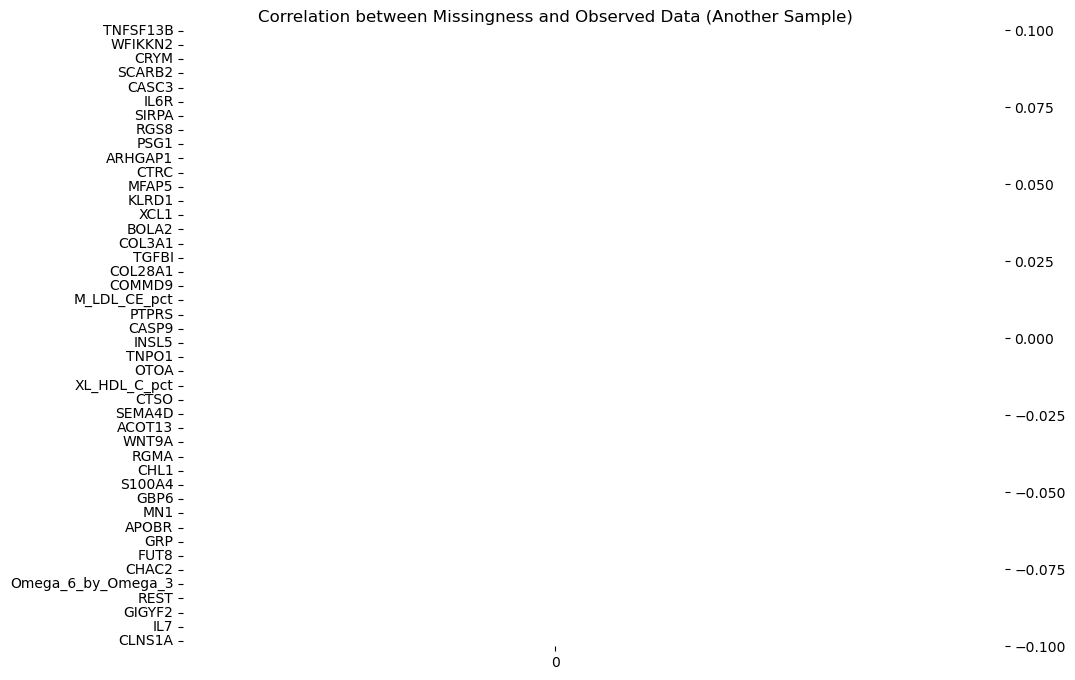

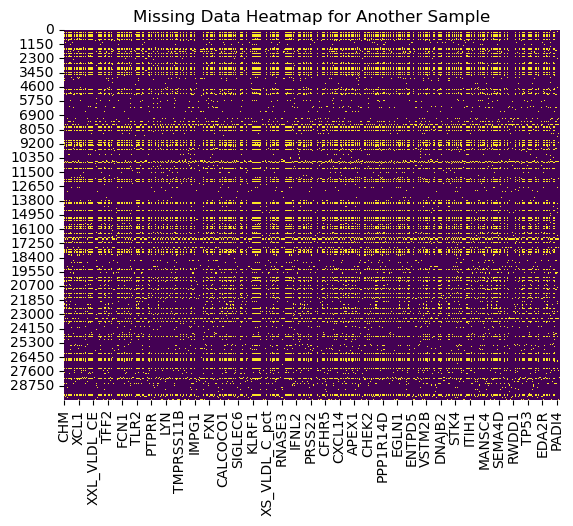

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


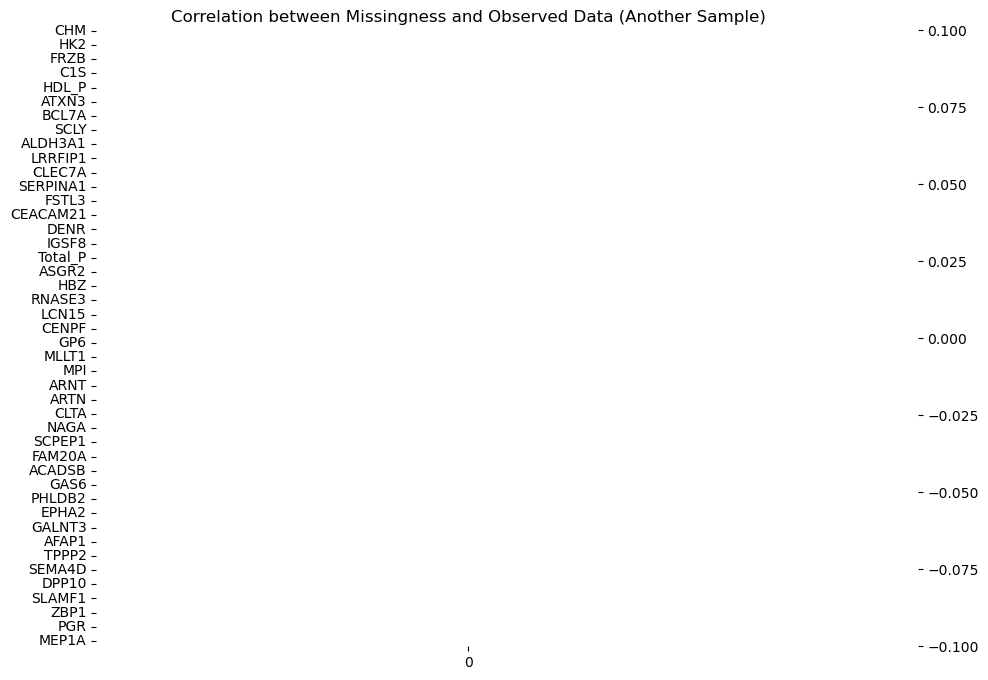

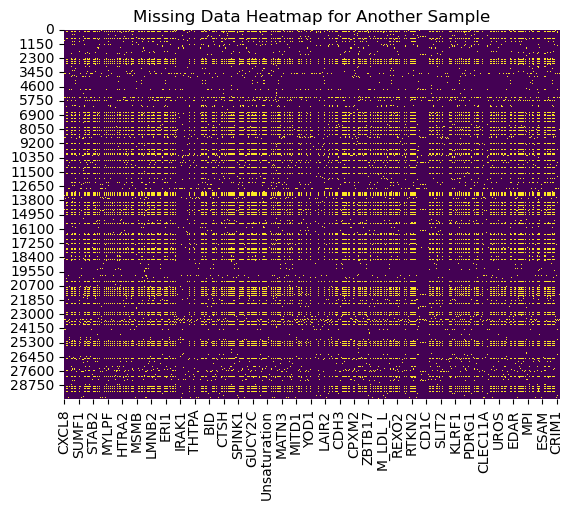

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


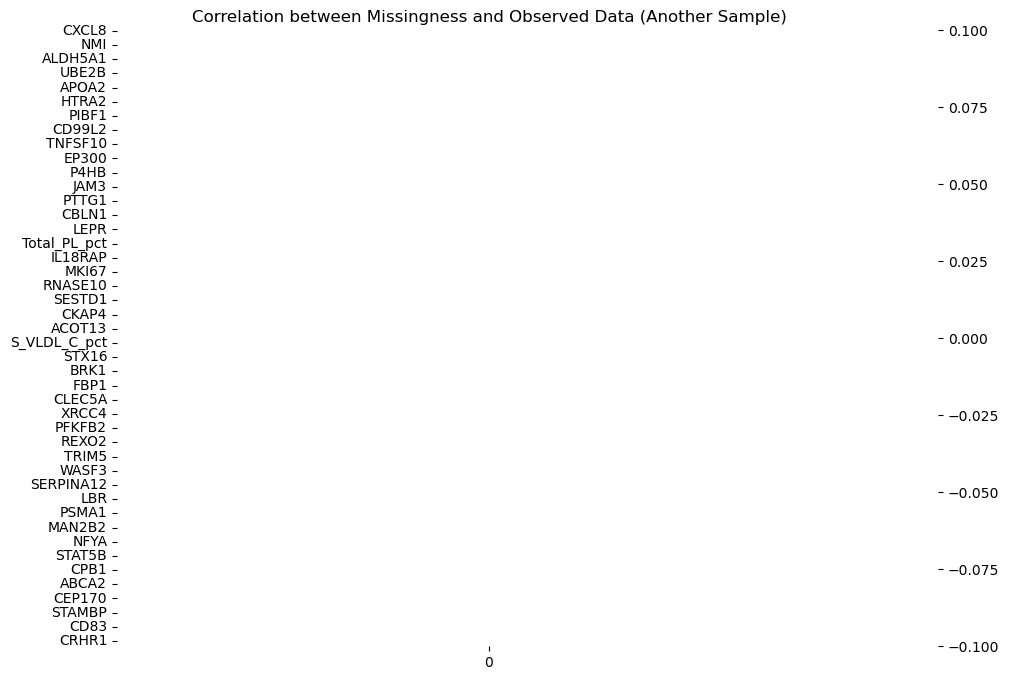

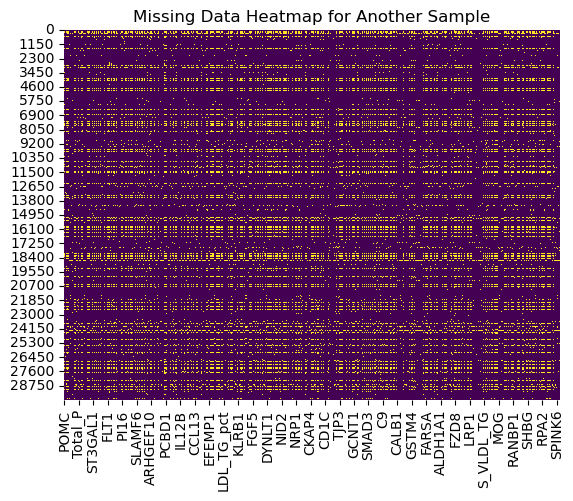

/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/share/apps/centos7/anaconda3/2023.03/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


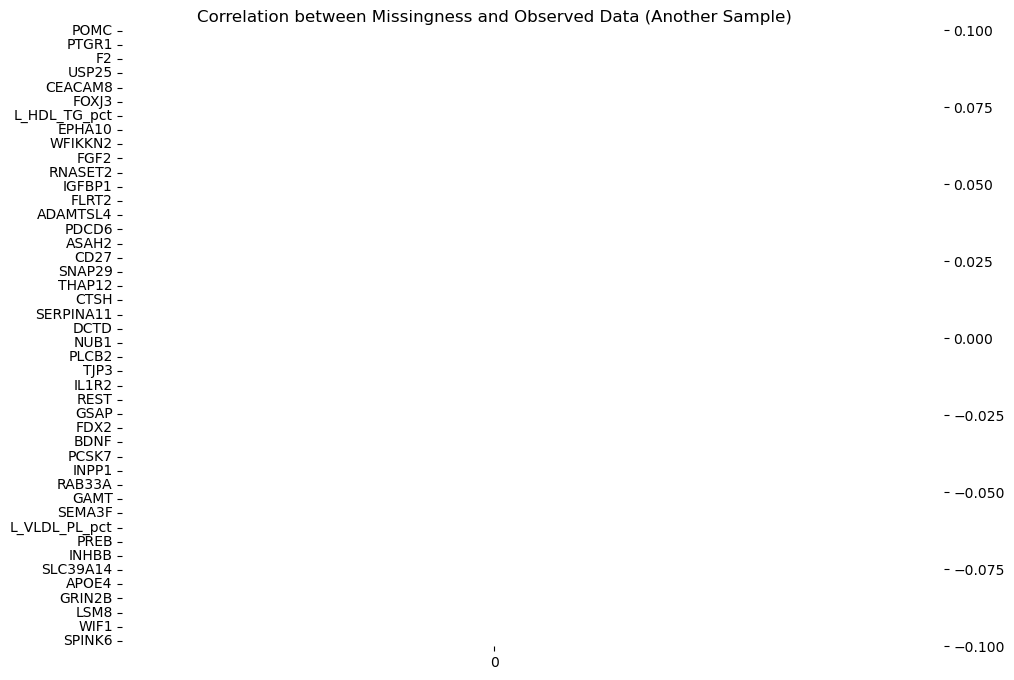

In [78]:
#MCAR/MAR analysis 

# Repeat the sampling and analysis for consistency
for _ in range(5):  # Repeat 5 times
    sampled_columns = np.random.choice(data.columns, size=int(0.2 * len(data.columns)), replace=False)
    sampled_data = data[sampled_columns]

    # Heatmap for missing data
    sns.heatmap(sampled_data.isnull(), cbar=False, cmap="viridis")
    plt.title('Missing Data Heatmap for Another Sample')
    plt.show()

    # Correlation matrix between missing indicators and actual data
    missing_indicators = sampled_data.isnull().astype(int)
    correlation_matrix = missing_indicators.corrwith(sampled_data, axis=0)

    # Plotting the correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix.to_frame(), annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation between Missingness and Observed Data (Another Sample)')
    plt.show()


In [54]:
dataset_nomissing_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29878 entries, 0 to 29877
Columns: 3258 entries, eid to Years_Group
dtypes: float64(3247), int64(5), object(6)
memory usage: 742.7+ MB


### Descriptive statistics

In [79]:
data_stats = dataset_nomissing_filtered

In [80]:
data_stats.head()

,eid,gender,age_at_baseline,ethnicity,years_education,ethnic_group,BMI_levels,LTFU,dementia_diagnosis,dementia_date,...,Total_FC_pct,Total_C_pct,Total_PL_pct,Total_TG_pct,Total_FC_pct_C,Total_CE_pct_C,Total_FC_by_CE,Omega_3_pct_PUFA,Omega_6_pct_PUFA,Years_Group
0,1000644,Female,52,British,10.0,White,Overweight,No,0,NaN,...,13.612703,49.139841,31.813449,19.046711,27.701968,72.298032,0.383164,6.847441,93.152559,0.0
1,1000700,Female,64,British,16.0,White,Overweight,No,0,NaN,...,14.651346,54.684148,34.909830,10.406021,26.792674,73.207326,0.365984,12.454808,87.545192,0.0
2,1001054,Female,64,British,10.0,White,Obese,No,0,NaN,...,14.952430,52.019105,30.727516,17.253378,28.744111,71.255889,0.403393,14.291576,85.708424,0.0
3,1001149,Female,42,British,16.0,White,Normal,No,0,NaN,...,13.662934,50.888036,35.656855,13.455109,26.849010,73.150990,0.367035,8.454628,91.545372,0.0
4,1001350,Female,57,British,12.0,White,Overweight,No,0,NaN,...,14.355283,50.094429,29.449679,20.455892,28.656446,71.343554,0.401668,14.355765,85.644235,0.0


In [81]:
# Print the names of the columns
print("Column names:", data_stats.columns.tolist())

Column names: ['eid', 'gender', 'age_at_baseline', 'ethnicity', 'years_education', 'ethnic_group', 'BMI_levels', 'LTFU', 'dementia_diagnosis', 'dementia_date', 'dementia_prevalence', 'dementia_incidence', 'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline', 'APOE4_alleles', 'APOE4', 'AAMDC', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1', 'AHS

In [82]:
data_stats.APOE4.value_counts()

0.0    28856
1.0      897
Name: APOE4, dtype: int64

In [83]:
data_stats.APOE4_alleles.value_counts()

0.0    21109
1.0     7747
2.0      897
Name: APOE4_alleles, dtype: int64

In [84]:
data_stats.dementia_diagnosis.value_counts()

0    29006
1      872
Name: dementia_diagnosis, dtype: int64

In [85]:
# Check for missing data in the specified variables
#do not concatenate results
variables_of_interest = ['gender', 'age_at_baseline', 'years_education', 'ethnic_group', 'BMI_levels', 'APOE4_alleles', 'APOE4']

missing_data = data_stats[variables_of_interest].isnull().sum()
print(missing_data)

gender               0
age_at_baseline      0
years_education    429
ethnic_group         0
BMI_levels           0
APOE4_alleles      125
APOE4              125
dtype: int64


In [86]:
#do not concatenate results
pd.set_option('display.max_rows', data_stats.shape[0]+1)

missing_data_all = data_stats.isnull().sum()
print(missing_data_all)

eid                                   0
gender                                0
age_at_baseline                       0
ethnicity                            32
years_education                     429
ethnic_group                          0
BMI_levels                            0
LTFU                                  0
dementia_diagnosis                    0
dementia_date                     29006
dementia_prevalence               29006
dementia_incidence                29006
Diagnosis_since_baseline              0
Diagnosis_years_since_baseline    29006
APOE4_alleles                       125
APOE4                               125
AAMDC                              5656
ABCA2                              5784
ABHD14B                            1010
ABL1                                794
ABO                                4993
ABRAXAS2                           5784
ACAA1                              1285
ACADM                              5454
ACADSB                             4981


In [87]:
data_stats.describe()

,eid,age_at_baseline,years_education,dementia_diagnosis,dementia_prevalence,dementia_incidence,Diagnosis_since_baseline,Diagnosis_years_since_baseline,APOE4_alleles,APOE4,...,Total_FC_pct,Total_C_pct,Total_PL_pct,Total_TG_pct,Total_FC_pct_C,Total_CE_pct_C,Total_FC_by_CE,Omega_3_pct_PUFA,Omega_6_pct_PUFA,Years_Group
count,2.987800e+04,29878.000000,29449.000000,29878.000000,872.0,872.0,29878.000000,872.000000,29753.000000,29753.000000,...,29287.000000,29287.000000,29287.000000,29287.000000,29418.000000,29418.000000,29418.000000,29582.000000,29582.000000,29878.00000
mean,3.507180e+06,56.908428,13.051886,0.029185,0.0,1.0,4.949026,8.961088,0.320674,0.030148,...,14.230570,51.986799,33.276227,14.736974,27.402440,72.597560,0.377683,10.403684,89.596316,0.09579
std,1.452054e+06,8.190909,2.817316,0.168329,0.0,0.0,0.321459,3.368365,0.527397,0.170998,...,1.113633,4.304473,2.118851,5.215267,0.928432,0.928432,0.017676,3.448199,3.448199,0.56507
min,1.000644e+06,39.000000,0.000000,0.000000,0.0,1.0,1.000000,0.175342,0.000000,0.000000,...,8.493110,24.256191,26.428284,4.268111,23.245697,64.985804,0.302859,0.050905,59.028610,0.00000
25%,2.242998e+06,50.000000,11.000000,0.000000,0.0,1.0,5.000000,6.661644,0.000000,0.000000,...,13.559261,49.479267,31.723096,10.695151,26.757017,71.972684,0.365319,8.039601,87.696041,0.00000
50%,3.504096e+06,58.000000,12.000000,0.000000,0.0,1.0,5.000000,9.265753,0.000000,0.000000,...,14.337656,52.658621,33.173827,14.000641,27.389298,72.610702,0.377207,10.010640,89.989360,0.00000
75%,4.762702e+06,64.000000,16.000000,0.000000,0.0,1.0,5.000000,11.741781,1.000000,0.000000,...,15.019018,55.158690,34.731680,18.048718,28.027316,73.242983,0.389416,12.303959,91.960399,0.00000
max,6.023876e+06,70.000000,30.000000,1.000000,0.0,1.0,5.000000,15.213699,2.000000,1.000000,...,17.702824,63.102199,42.882553,48.316240,35.014196,76.754303,0.538798,40.971390,99.949095,4.00000


### Imputing just the variables for summary stats

In [88]:
from sklearn.impute import KNNImputer

variables_input = ['years_education','APOE4_alleles', 'APOE4']

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
data_stats_imputed = data_stats.copy()
data_stats_imputed[variables_input] = imputer.fit_transform(data_stats[variables_input])

# Round the imputed values to the nearest valid category for APOE4_alleles and APOE4
data_stats_imputed['APOE4_alleles'] = data_stats_imputed['APOE4_alleles'].round().astype(int)
data_stats_imputed['APOE4'] = data_stats_imputed['APOE4'].round().astype(int)

# Ensure the imputed values fall within the original categories
data_stats_imputed['APOE4_alleles'] = data_stats_imputed['APOE4_alleles'].clip(lower=0, upper=2)
data_stats_imputed['APOE4'] = data_stats_imputed['APOE4'].clip(lower=0, upper=1)

# Verify the value counts after imputation and rounding
print(data_stats_imputed['APOE4_alleles'].value_counts())
print(data_stats_imputed['APOE4'].value_counts())

0    21233
1     7748
2      897
Name: APOE4_alleles, dtype: int64
0    28981
1      897
Name: APOE4, dtype: int64


In [89]:
# Check for missing data after imputation
missing_data_after_imputation = data_stats_imputed[variables_of_interest].isnull().sum()
print("\nMissing data in each variable after KNN imputation:")
print(missing_data_after_imputation)



Missing data in each variable after KNN imputation:
gender             0
age_at_baseline    0
years_education    0
ethnic_group       0
BMI_levels         0
APOE4_alleles      0
APOE4              0
dtype: int64


In [90]:
data_stats_imputed.APOE4_alleles.value_counts()

0    21233
1     7748
2      897
Name: APOE4_alleles, dtype: int64

In [91]:
data_stats_imputed.APOE4.value_counts()

0    28981
1      897
Name: APOE4, dtype: int64

In [92]:
variables_of_interest = ['gender', 'age_at_baseline', 'years_education', 'ethnic_group', 'BMI_levels', 'APOE4_alleles', 'APOE4']

# Split the DataFrame based on dementia diagnosis
df_dementia = data_stats_imputed[data_stats_imputed['dementia_diagnosis'] == 1]
df_no_dementia = data_stats_imputed[data_stats_imputed['dementia_diagnosis'] == 0]

# Compute summary statistics for each group
summary_dementia = df_dementia[variables_of_interest].describe(include='all')
summary_no_dementia = df_no_dementia[variables_of_interest].describe(include='all')

# Combine the results into a single DataFrame
summary_combined = pd.concat([summary_dementia, summary_no_dementia], axis=1, keys=['Dementia', 'No Dementia'])

# Display the combined summary statistics
print("Summary Statistics by Dementia Diagnosis:")
print(summary_combined)

Summary Statistics by Dementia Diagnosis:
       Dementia                                                           \
         gender age_at_baseline years_education ethnic_group  BMI_levels   
count       872      872.000000      872.000000          872         872   
unique        2             NaN             NaN            6           5   
top        Male             NaN             NaN        White  Overweight   
freq        450             NaN             NaN          840         371   
mean        NaN       64.548165       12.181422          NaN         NaN   
std         NaN        5.081198        2.814441          NaN         NaN   
min         NaN       40.000000        0.000000          NaN         NaN   
25%         NaN       63.000000       10.000000          NaN         NaN   
50%         NaN       66.000000       11.000000          NaN         NaN   
75%         NaN       68.000000       16.000000          NaN         NaN   
max         NaN       70.000000       27.00000

### Summary descriptive statistics and p-values

In [93]:
from scipy import stats

# Function to calculate median and IQR
def median_iqr(series):
    median = series.median()
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    return f"{median} [{q25}-{q75}]"

# Function to format p-values with significance stars
def format_p_value(p):
    if p < 0.001:
        return f"{p:.2e}***"
    elif p < 0.01:
        return f"{p:.2e}**"
    elif p < 0.05:
        return f"{p:.2e}*"
    else:
        return f"{p:.2e} (ns)"

# Summary statistics for continuous variables
summary_continuous = {
    'Variable': [],
    'No Dementia (median [IQR])': [],
    'Dementia (median [IQR])': [],
    'p-value': []
}

for var in ['age_at_baseline', 'years_education']:
    summary_continuous['Variable'].append(var)
    summary_continuous['No Dementia (median [IQR])'].append(median_iqr(df_no_dementia[var]))
    summary_continuous['Dementia (median [IQR])'].append(median_iqr(df_dementia[var]))
    t_stat, p_val = stats.ttest_ind(df_no_dementia[var], df_dementia[var], nan_policy='omit')
    summary_continuous['p-value'].append(format_p_value(p_val))

summary_continuous_df = pd.DataFrame(summary_continuous)

# Summary statistics for categorical variables
summary_categorical = []

for var in ['gender', 'ethnic_group', 'BMI_levels', 'APOE4_alleles', 'APOE4']:
    no_dementia_counts = df_no_dementia[var].value_counts().sort_index()
    dementia_counts = df_dementia[var].value_counts().sort_index()
    no_dementia_perc = (no_dementia_counts / len(df_no_dementia) * 100).round(2)
    dementia_perc = (dementia_counts / len(df_dementia) * 100).round(2)
    
    chi2, p_val = stats.chi2_contingency(pd.concat([no_dementia_counts, dementia_counts], axis=1, keys=['No Dementia', 'Dementia']).fillna(0).astype(int))[0:2]
    
    for idx in no_dementia_counts.index.union(dementia_counts.index):
        summary_categorical.append({
            'Variable': var,
            'Category': idx,
            'No Dementia (n [%])': f"{no_dementia_counts.get(idx, 0)} ({no_dementia_perc.get(idx, 0.0)}%)",
            'Dementia (n [%])': f"{dementia_counts.get(idx, 0)} ({dementia_perc.get(idx, 0.0)}%)",
            'p-value': format_p_value(p_val)
        })

summary_categorical_df = pd.DataFrame(summary_categorical)

# Display results using standard print statements
print("Continuous Variables Summary:")
print(summary_continuous_df.to_string(index=False))

print("\nCategorical Variables Summary:")
print(summary_categorical_df.to_string(index=False))


Continuous Variables Summary:
       Variable No Dementia (median [IQR]) Dementia (median [IQR])      p-value
age_at_baseline           58.0 [50.0-63.0]        66.0 [63.0-68.0] 3.34e-174***
years_education           12.0 [11.0-16.0]        11.0 [10.0-16.0]  7.34e-20***

Categorical Variables Summary:
     Variable    Category No Dementia (n [%]) Dementia (n [%])       p-value
       gender      Female      15715 (54.18%)     422 (48.39%)   8.31e-04***
       gender        Male      13291 (45.82%)     450 (51.61%)   8.31e-04***
 ethnic_group       Black         588 (2.03%)       15 (1.72%)     3.30e-02*
 ethnic_group     Chinese           87 (0.3%)         0 (0.0%)     3.30e-02*
 ethnic_group       Mixed         189 (0.65%)        3 (0.34%)     3.30e-02*
 ethnic_group       Other         307 (1.06%)        6 (0.69%)     3.30e-02*
 ethnic_group     S.Asian         491 (1.69%)        4 (0.46%)     3.30e-02*
 ethnic_group  Unknown/NA         127 (0.44%)        4 (0.46%)     3.30e-02*
 ethn

### Graphs to check data

/tmp/3759263.1.all.q/ipykernel_135103/1380693314.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "age_at_baseline"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
/tmp/3759263.1.all.q/ipykernel_135103/1380693314.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "age_at_baseline"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)


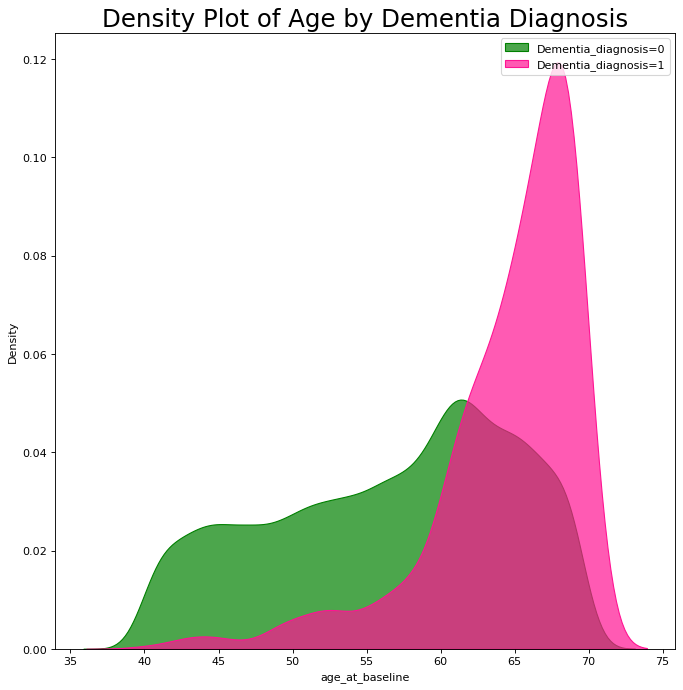

In [69]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(10,10), dpi= 80) #create figure

#Define Plot type, configure Age categories against Depression, define shade, color, labels and transparency
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "age_at_baseline"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "age_at_baseline"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)

# Title and show plot
plt.title('Density Plot of Age by Dementia Diagnosis', fontsize=22)
plt.legend()
plt.show()
# Save the boxplot as a file in the output directory
plt.savefig(os.path.join(output_dir, 'Density Plot of Age by Dementia Diagnosis.png'))
plt.close()  # Close the plot to free up memory

/tmp/3759263.1.all.q/ipykernel_135103/1362760706.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "years_education"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
/tmp/3759263.1.all.q/ipykernel_135103/1362760706.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "years_education"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)


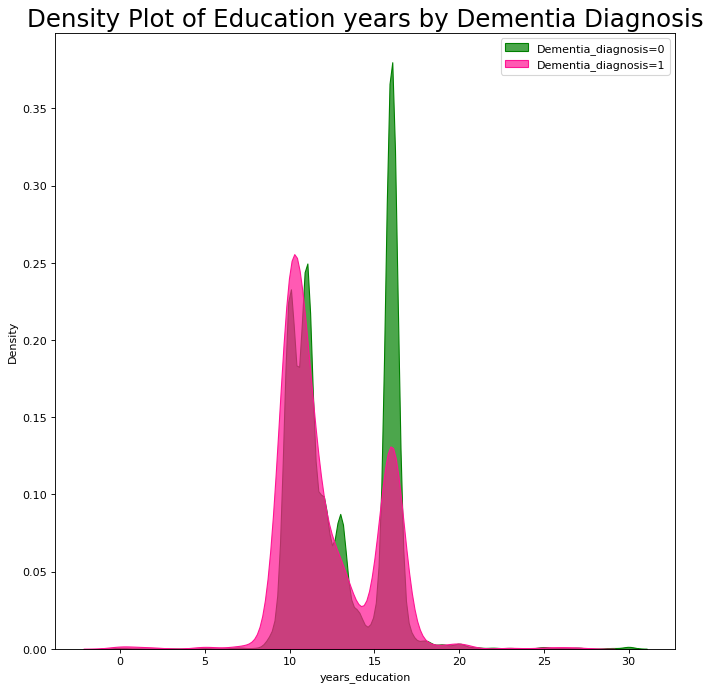

In [70]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(10,10), dpi= 80) #create figure

#Define Plot type, configure Age categories against Depression, define shade, color, labels and transparency
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "years_education"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "years_education"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)

# Title and show plot
plt.title('Density Plot of Education years by Dementia Diagnosis', fontsize=22)
plt.legend()
plt.show()
# Save the boxplot as a file in the output directory
plt.savefig(os.path.join(output_dir, 'Density Plot of Education years by Dementia Diagnosi.png'))
plt.close()  # Close the plot to free up memory

/tmp/3759263.1.all.q/ipykernel_135103/2714694881.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "APOE4_alleles"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
/tmp/3759263.1.all.q/ipykernel_135103/2714694881.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "APOE4_alleles"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)


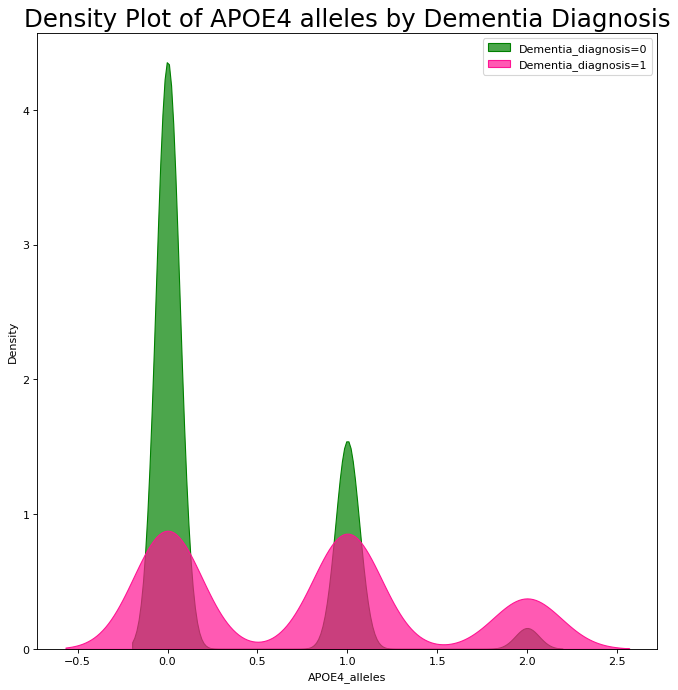

In [71]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(10,10), dpi= 80) #create figure

#Define Plot type, configure Age categories against Depression, define shade, color, labels and transparency
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "APOE4_alleles"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "APOE4_alleles"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)

# Title and show plot
plt.title('Density Plot of APOE4 alleles by Dementia Diagnosis', fontsize=22)
plt.legend()
plt.show()
# Save the boxplot as a file in the output directory
plt.savefig(os.path.join(output_dir, 'Density Plot of APOE4 alleles by Dementia Diagnosis.png'))
plt.close()  # Close the plot to free up memory

/tmp/3759263.1.all.q/ipykernel_135103/4078412278.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "APOE4"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
/tmp/3759263.1.all.q/ipykernel_135103/4078412278.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "APOE4"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)


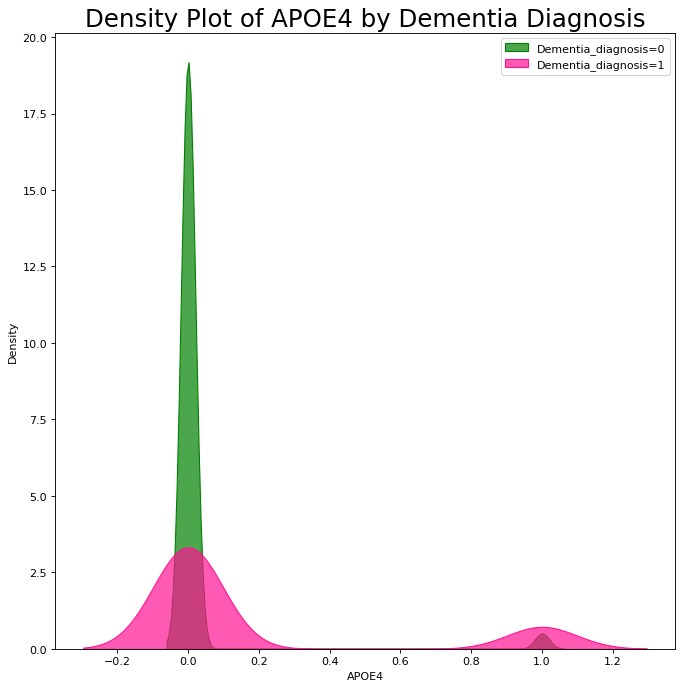

In [72]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(10,10), dpi= 80) #create figure

#Define Plot type, configure Age categories against Depression, define shade, color, labels and transparency
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 0, "APOE4"], shade=True, color="g", label="Dementia_diagnosis=0", alpha=.7)
sns.kdeplot(data_stats_imputed.loc[data_stats_imputed['dementia_diagnosis'] == 1, "APOE4"], shade=True, color="deeppink", label="Dementia_diagnosis=1", alpha=.7)

# Title and show plot
plt.title('Density Plot of APOE4 by Dementia Diagnosis', fontsize=22)
plt.legend()
plt.show()
# Save the boxplot as a file in the output directory
plt.savefig(os.path.join(output_dir, 'Density Plot of APOE4 by Dementia Diagnosis.png'))
plt.close()  # Close the plot to free up memory

In [73]:
data_stats_imputed.isnull().sum()

eid                                   0
gender                                0
age_at_baseline                       0
ethnicity                            32
years_education                       0
ethnic_group                          0
BMI_levels                            0
LTFU                                  0
dementia_diagnosis                    0
dementia_date                     29006
dementia_prevalence               29006
dementia_incidence                29006
Diagnosis_since_baseline              0
Diagnosis_years_since_baseline    29006
APOE4_alleles                         0
APOE4                                 0
AAMDC                              5656
ABCA2                              5784
ABHD14B                            1010
ABL1                                794
ABO                                4993
ABRAXAS2                           5784
ACAA1                              1285
ACADM                              5454
ACADSB                             4981


In [74]:
print(data_stats_imputed.columns.tolist())

['eid', 'gender', 'age_at_baseline', 'ethnicity', 'years_education', 'ethnic_group', 'BMI_levels', 'LTFU', 'dementia_diagnosis', 'dementia_date', 'dementia_prevalence', 'dementia_incidence', 'Diagnosis_since_baseline', 'Diagnosis_years_since_baseline', 'APOE4_alleles', 'APOE4', 'AAMDC', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1', 'AHSG', 'AHSP', 'A

### Imputing missing data with KNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Check data types of all columns
data_types = data_stats_imputed.dtypes

# Identify categorical variables
categorical_columns = data_types[data_types == 'object'].index.tolist()
print(f'Categorical columns: {categorical_columns}')

# Convert the 'APOE4_alleles' column to categorical
data_stats_imputed['APOE4_alleles'] = data_stats_imputed['APOE4_alleles'].astype('category')

# Add 'APOE4_alleles' to the list of categorical columns if not already present
if 'APOE4_alleles' not in categorical_columns:
    categorical_columns.append('APOE4_alleles')

# Identify numeric columns
numeric_columns = [col for col in data_stats_imputed if col not in categorical_columns]

# Replace any infinity values (np.inf and -np.inf) with NaN
data_stats_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert non-numeric values in numeric columns to NaN
for col in numeric_columns:
    data_stats_imputed[col] = pd.to_numeric(data_stats_imputed[col], errors='coerce')

# Apply KNN imputation for numeric features
knn_imputer = KNNImputer(n_neighbors=5)
data_stats_imputed[numeric_columns] = knn_imputer.fit_transform(data_stats_imputed[numeric_columns])

# Save the imputed dataset to a CSV file
data_stats_imputed.to_csv('data_stats_imputed_knn.csv', index=False)

# Verify the imputation
print("KNN imputation completed and dataset saved to 'data_stats_imputed_knn.csv'.")